# ETL

## IMPORT LIBRARIES

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import regex as re
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import requests
import io

pd.set_option('display.max_columns', 500)
register_matplotlib_converters()

## GET DATA

Thanks due to Joris Hoendervangers (https://www.pythonsherpa.com) for designing the get_data() function to retrieve data from the Bank of England's Statistical Interactice Database. See this article: https://www.datacareer.co.uk/blog/bank-of-england-s-statistical-interactive-database-iadb-using-python/. 

In [3]:
def get_data(series):
    global df
    url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
    payload = {
    'Datefrom'   : '01/Jan/2000',
    'Dateto'     : '15/Dec/2023',
    'SeriesCodes': series,
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                      'AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/54.0.2840.90 '
                      'Safari/537.36'
    }
    response = requests.get(url_endpoint, params=payload, headers=headers)
    print(response.status_code, response.url)
    return pd.read_csv(io.BytesIO(response.content), index_col=0, parse_dates=True)

### DATA ABOUT LENDING

In [4]:
monthly = get_data('RPMZ8Y2,RPMZ8Y3,RPMZ8Y5,RPMZ8Y6,RPMZ8YH,RPMZ8YI')
quarterly = get_data('RPQZ8Y2,RPQZ8Y3,RPQZ8Y5,RPQZ8Y6,RPQZ8YH,RPQZ8YI')

200 https://www.bankofengland.co.uk/boeapps/database/_iadb-FromShowColumns.asp?csv.x=yes&Datefrom=01%2FJan%2F2000&Dateto=15%2FDec%2F2023&SeriesCodes=RPMZ8Y2%2CRPMZ8Y3%2CRPMZ8Y5%2CRPMZ8Y6%2CRPMZ8YH%2CRPMZ8YI&CSVF=TN&UsingCodes=Y&VPD=Y&VFD=N
200 https://www.bankofengland.co.uk/boeapps/database/_iadb-FromShowColumns.asp?csv.x=yes&Datefrom=01%2FJan%2F2000&Dateto=15%2FDec%2F2023&SeriesCodes=RPQZ8Y2%2CRPQZ8Y3%2CRPQZ8Y5%2CRPQZ8Y6%2CRPQZ8YH%2CRPQZ8YI&CSVF=TN&UsingCodes=Y&VPD=Y&VFD=N


### DATA RELATED TO LENDING

In [5]:
mfi_bs = get_data('RPMB3ZN,RPMB3UQ') #Total Liabilities and Total Assets
bankrate = pd.read_csv('/kaggle/input/bankrate/BankRate.csv')

200 https://www.bankofengland.co.uk/boeapps/database/_iadb-FromShowColumns.asp?csv.x=yes&Datefrom=01%2FJan%2F2000&Dateto=15%2FDec%2F2023&SeriesCodes=RPMB3ZN%2CRPMB3UQ&CSVF=TN&UsingCodes=Y&VPD=Y&VFD=N


In [6]:
#Copy and pasted from the table at https://www.fxstreet.com/economic-calendar/event/f21a55ef-8d4b-4970-8f7e-0100bae77407#Content_C025_Col00
pmi = """01/02/2024 (Dec)	46.2	-0.21	46.4
12/01/2023 (Nov)	47.2	0.78	46.6
11/01/2023 (Oct)	44.8	-0.32	45.2
10/02/2023 (Sep)	44.3	0.08	44.2
09/01/2023 (Aug)	43	0.48	42.5
08/01/2023 (Jul)	45.3	0.49	45
07/03/2023 (Jun)	46.5	0.28	46.2
06/01/2023 (May)	47.1	0.17	46.9
05/02/2023 (Apr)	47.8	0.77	46.6
04/03/2023 (Mar)	47.9	-0.07	48
03/01/2023 (Feb)	49.3	0.07	49.2
02/01/2023 (Jan)	47	0.28	46.7
01/03/2023 (Dec)	45.3	0.53	44.7
12/01/2022 (Nov)	46.5	0.27	46.2
11/01/2022 (Oct)	46.2	0.17	45.8
10/03/2022 (Sep)	48.4	-0.04	48.5
09/01/2022 (Aug)	47.3	0.66	46
08/01/2022 (Jul)	52.1	-0.33	52.2
07/01/2022 (Jun)	52.8	-0.93	53.4
06/01/2022 (May)	54.6	0.00	54.6
05/03/2022 (Apr)	55.8	0.59	55.3
04/01/2022 (Mar)	55.2	-0.39	55.5
03/01/2022 (Feb)	58	1.40	57.3
02/01/2022 (Jan)	57.3	0.65	56.9
01/04/2022 (Dec)	57.9	0.40	57.6
12/01/2021 (Nov)	58.1	-0.06	58.2
11/01/2021 (Oct)	57.8	0.07	57.7
10/01/2021 (Sep)	57.1	0.60	56.3
09/01/2021 (Aug)	60.3	0.21	60.1
08/02/2021 (Jul)	60.4	0.00	60.4
07/01/2021 (Jun)	63.9	-0.13	64.2
06/01/2021 (May)	65.6	-0.24	66.1
05/04/2021 (Apr)	60.9	0.22	60.7
04/01/2021 (Mar)	58.9	0.74	57.9
03/01/2021 (Feb)	55.1	0.20	54.9
02/01/2021 (Jan)	54.1	0.61	52.9
01/04/2021 (Dec)	57.5	0.12	57.3
12/01/2020 (Nov)	55.6	0.22	55.2
11/02/2020 (Oct)	53.7	0.64	53.3
10/01/2020 (Sep)	54.1	-0.24	54.3
09/01/2020 (Aug)	55.2	-0.05	55.3
08/03/2020 (Jul)	53.3	-0.14	53.6
07/01/2020 (Jun)	50.1	0.00	50.1
06/01/2020 (May)	40.7	0.00	40.7
05/01/2020 (Apr)	32.6	-0.05	32.8
04/01/2020 (Mar)	47.8	0.68	47
03/02/2020 (Feb)	51.7	-0.07	51.8
02/03/2020 (Jan)	50	0.20	49.8
01/02/2020 (Dec)	47.5	-0.08	47.6
12/02/2019 (Nov)	48.9	0.59	48.3
11/01/2019 (Oct)	49.6	1.12	48.1
10/01/2019 (Sep)	48.3	1.25	47
09/02/2019 (Aug)	47.4	-0.45	48.4
08/01/2019 (Jul)	48	0.13	47.7
07/01/2019 (Jun)	48	-0.55	49.2
06/03/2019 (May)	49.4	-1.51	52
05/01/2019 (Apr)	53.1	0.06	53
04/01/2019 (Mar)	55.1	3.12	51
03/01/2019 (Feb)	52.1 	0.00	52
02/01/2019 (Jan)	52.6 	-0.48	53.5
01/02/2019 (Dec)	54.2	1.35	52.5
12/03/2018 (Nov)	53.6 	1.18	51.8
11/01/2018 (Oct)	51.1	-2.34	53
10/01/2018 (Sep)	53.6 	1.77	52.5
09/03/2018 (Aug)	53 	-1.62	53.8
08/01/2018 (Jul)	53.8 	-0.34	54.2
07/02/2018 (Jun)	54.3 	0.50	54
06/01/2018 (May)	54.3 	1.11	53.5
05/01/2018 (Apr)	53.9	-0.74	54.8
04/03/2018 (Mar)	54.9 	0.33	54.7
03/01/2018 (Feb)	55 	0.16	55
02/01/2018 (Jan)	55.3	-0.89	56.5
01/02/2018 (Dec)	56.2 	-1.96	58
12/01/2017 (Nov)	58.2	1.29	56.5
11/01/2017 (Oct)	56.6 	0.38	55.8
10/02/2017 (Sep)	55.9	-0.28	56.4
09/01/2017 (Aug)	56.9	1.06	55
08/01/2017 (Jul)	55.3 	0.44	54.3
07/03/2017 (Jun)	54.2 	-1.28	56.3
06/01/2017 (May)	56.3 	0.10	56.5
05/02/2017 (Apr)	57.3	2.08	54
04/03/2017 (Mar)	54.2	-0.59	55.1
03/01/2017 (Feb)	54.5 	-0.55	55.6
02/01/2017 (Jan)	55.9	0.00	55.9
01/03/2017 (Dec)	56.1	1.37	53
12/01/2016 (Nov)	53.6 	-0.49	54.5
11/01/2016 (Oct)	54.2 	-0.09	54.5
10/03/2016 (Sep)	55.5 	1.69	52.1
09/01/2016 (Aug)	53.3	3.19	49
08/01/2016 (Jul)	48.3 	-0.69	49.1
07/01/2016 (Jun)	52.1	1.65	50.2
06/01/2016 (May)	50.1	0.47	49.6
05/03/2016 (Apr)	49.2	-2.33	51.2
04/01/2016 (Mar)	51	-0.10	51.2
03/01/2016 (Feb)	50.8	-0.75	52.2
02/01/2016 (Jan)	52.9	0.57	51.8
01/04/2016 (Dec)	52.1 	-0.44	52.7
12/01/2015 (Nov)	52.7	-0.48	53.6
11/02/2015 (Oct)	55.2 	8.15	51.3
10/01/2015 (Sep)	51.5	0.20	51.3
09/01/2015 (Aug)	51.6 	-0.46	52
08/03/2015 (Jul)	51.9	0.26	51.6
07/01/2015 (Jun)	51.4	-0.89	52.5
06/01/2015 (May)	51.9 	-0.40	52.5
05/01/2015 (Apr)	51.8 	-4.54	54.6
04/01/2015 (Mar)	54.4	0.10	54.3
03/02/2015 (Feb)	54.1	0.61	53.4
02/02/2015 (Jan)	53 	0.31	52.6
01/02/2015 (Dec)	52.5 	-0.56	53.7
12/01/2014 (Nov)	53.5 	0.16	53
11/03/2014 (Oct)	53.2 	1.56	51.2
10/01/2014 (Sep)	51.6 	-0.55	52.5
09/01/2014 (Aug)	52.5 	-1.93	55
08/01/2014 (Jul)	55.4 	-2.50	57.2
07/01/2014 (Jun)	57.5	0.73	56.8
06/02/2014 (May)	57	0.00	57
05/01/2014 (Apr)	57.3	1.73	55.4
04/01/2014 (Mar)	55.3 	-0.89	56.7
03/03/2014 (Feb)	56.9 	-0.27	56.5
02/03/2014 (Jan)	56.7	-0.22	57
01/02/2014 (Dec)	57.3 	-0.64	58
12/02/2013 (Nov)	58.4 	1.80	56
11/01/2013 (Oct)	56 	0.35	56.1
10/01/2013 (Sep)	56.7 	-2.27	57.3
09/02/2013 (Aug)	57.2	3.36	55
08/01/2013 (Jul)	54.6 	1.15	52.8
07/01/2013 (Jun)	52.5	0.59	51.5
06/03/2013 (May)	51.3 	0.70	50.2
05/01/2013 (Apr)	49.8 	0.96	48.5
04/02/2013 (Mar)	48.3 	0.06	48.5
03/01/2013 (Feb)	47.9	-2.60	51
02/01/2013 (Jan)	50.8 	-0.30	51
01/02/2013 (Dec)	51.4 	0.92	49.1
12/03/2012 (Nov)	49.1 	0.51	48
11/01/2012 (Oct)	47.5 	-0.24	48
10/01/2012 (Sep)	48.4 	-0.31	49
09/03/2012 (Aug)	49.5	1.51	46
08/01/2012 (Jul)	45.4 	-1.61	48.5
07/02/2012 (Jun)	48.6 	0.90	46.5
06/01/2012 (May)	45.9	-2.72	49.8
05/01/2012 (Apr)	50.5 	-1.28	51.5
04/02/2012 (Mar)	52.1 	0.71	50.7
03/01/2012 (Feb)	51.2 	-0.18	51.8
02/01/2012 (Jan)	52.1 	1.35	49.8
01/03/2012 (Dec)	49.6 	1.61	47.3
12/01/2011 (Nov)	47.6 	0.35	47.2
11/01/2011 (Oct)	47.4 	-1.51	50
10/03/2011 (Sep)	51.1 	1.86	48.9
09/01/2011 (Aug)	49 	-0.18	49.6
08/01/2011 (Jul)	49.1 	-1.26	51.1
07/01/2011 (Jun)	51.3 	-0.34	52.3
06/01/2011 (May)	52.1 	-0.82	54.3
05/03/2011 (Apr)	54.6 	-1.16	57.5
04/01/2011 (Mar)	57.1 	-3.17	60.9
03/01/2011 (Feb)	61.5 	-0.48	61.5
02/01/2011 (Jan)	62 	1.63	58.1
01/04/2011 (Dec)	58.7	0.69	57.3"""

In [7]:
pmi = pmi.replace('		',',').replace('	',',').replace(' ','')
pmi = re.sub(r'\([^()]*\)', '', pmi)
pmi = pmi.strip()
pmi = 'Date,Actual,Dev,Cons\n' + pmi
pmi = io.StringIO(pmi)
pmi = pd.read_csv(pmi, sep=',')

In [8]:
gfcf = pd.read_csv('/kaggle/input/gfcf-and-tbi-q-cp-nsa-csv/GFCF_and_TBI_CP_NSA.csv')

## TRANSFORM DATA

### Clean the dates

#### All dates to ISO 8061 (YYYY-MM-DD)


gfcfc had layered headers, cleaned in sheets the exported to csv ... Current Price used as opposed to chained volume measufre as lending stats are not adjusted for inflation (confirm?) 

In [9]:
bankrate['Date Changed'] = pd.to_datetime(bankrate['Date Changed'],format="%d %b %y")

In [10]:
pmi['Date'] = pd.to_datetime(pmi['Date'], format="%m/%d/%Y")

In [11]:
def fix_gfcf_dates(d):
        if 'Q1' in d:
            d = d[0:4] + '-03-01'
            return d
        if 'Q2' in d:
            d = d[0:4] + '-06-30'
            return d
        if 'Q3' in d:
            d = d[0:4] + '-09-30'
            return d
        if 'Q4' in d:
            d = d[0:4] + '-12-31'
            return d

gfcf['Date'] = pd.to_datetime(pmi['Date'], format="%Y-%m-%d")

In [12]:
bankrate = bankrate.rename(columns={'Date Changed': 'Date'})

In [13]:
mfi_bs = mfi_bs.rename(columns=
                      {'RPMB3ZN': 'TOTAL_LIABILITIES_STER_NSA',
                       'RPMB3UQ': 'TOTAL_ASSETS_STER_NSA'})

#### All Dates to index

In [14]:
pmi.Date

0     2024-01-02
1     2023-12-01
2     2023-11-01
3     2023-10-02
4     2023-09-01
         ...    
152   2011-05-03
153   2011-04-01
154   2011-03-01
155   2011-02-01
156   2011-01-04
Name: Date, Length: 157, dtype: datetime64[ns]

In [15]:
bankrate = bankrate.set_index('Date')
pmi = pmi.set_index('Date')
gfcf = gfcf.set_index('Date')

In [16]:
data = [monthly, quarterly, mfi_bs, bankrate, pmi, gfcf, mfi_bs]

strs  = ['monthly', 'quarterly', 'mfi_bs', 'bankrate', 'pmi', 'gfcf', 'mfi_bs']

i=0
for x in data:
    print(f"{strs[i]} is {x.index.dtype} e.g. {x.index[0]}.")
    i+=1

monthly is datetime64[ns] e.g. 2011-04-30 00:00:00.
quarterly is datetime64[ns] e.g. 2011-06-30 00:00:00.
mfi_bs is datetime64[ns] e.g. 2010-01-31 00:00:00.
bankrate is datetime64[ns] e.g. 2023-08-03 00:00:00.
pmi is datetime64[ns] e.g. 2024-01-02 00:00:00.
gfcf is datetime64[ns] e.g. 2024-01-02 00:00:00.
mfi_bs is datetime64[ns] e.g. 2010-01-31 00:00:00.


### Renaming and removing columns

In [17]:
monthly = monthly.rename(columns = 
                         {'RPMZ8Y2': 'SME_GROSS_LEND_NSA',
                          'RPMZ8Y3': 'LRG_GROSS_LEND_NSA',
                          'RPMZ8Y5': 'SME_GROSS_REPAY_NSA',
                          'RPMZ8Y6': 'LRG_GROSS_REPAY_NSA',
                          'RPMZ8YH': 'LRG_GROSS_OUTSTANDING_NSA',
                          'RPMZ8YI': 'SME_GROSS_OUTSTANDING_NSA'})
quarterly = quarterly.rename(columns=
                            {'RPQZ8Y3': 'LRG_GROSS_LEND_exOD_NSA',
                             'RPQZ8Y6': 'LRG_GROSS_REPAY_exOD_NSA',
                             'RPQZ8Y2': 'SME_GROSS_LEND_exOD_NSA',
                             'RPQZ8Y5': 'SME_GROSS_REPAY_exOD_NSA',
                             'RPQZ8YI': 'LRG_GROSS_OUTSTANDING_NSA',
                             'RPQZ8YH': 'SME_GROSS_OUTSTANDING_NSA'})

In [18]:
pmi['Actual_Bullish'] = pmi.Actual.copy().apply(lambda x: 'Y' if x > 50 else 'N')
pmi['Cons_Bullish'] = pmi.Cons.copy().apply(lambda x: 'Y' if x > 50 else 'N')

In [19]:
gfcf = gfcf[::-1]

# DEALING WITH THE TIME SERIES DATA

FUNCTIONALISE! 1 for series within df, 2 super function aggregating key outputs

Seasonality ... trend in data with fixed amplitutde and period, with vayring period would be described as a cycle not seasonality

T = S + C + e (additive)

1. Plot with trend line (polyfit)
2. Is there seasonaity?
    i. Visual
    ii. Statsmodels decomposee -- what assumptions?
3. If so, what type -- additive or multiplicative? 
3a. What errors/residuals to account for e.g. 2019/20? 
4. Adjusting --
    i. Subtract exact value in previous period
    ii. Subtract average of previous period
    iii. Some kind of moving avg assessed by T&E
5. How to assess success of seasonal adjustment? 

In [41]:
monthly_all = monthly.join([bankrate,gfcf,pmi,mfi_bs],how='outer').loc['2011-04-30':]
quarterly_all = quarterly.join([bankrate,gfcf,pmi,mfi_bs],how='outer').loc['2011-06-30':]
monthly_all.Rate.loc['2011-04-30'] = 0.5
quarterly_all.Rate.loc['2011-06-30'] = 0.5

Will propogate over NAN values on a case-by-case basis.

## Augmented Dickey-Fuller Test

H0: the time series is stationary, HA: the time series is non-stationary.

In [21]:
def adftest(df, t):
    for c in df.columns:
        if df[c].dtype == object:
            pass 
        else:
            result = adfuller(df[c].dropna())
            if result[1] > t:
                print(f'H0 rejected at {t} signifigance, {c} is non-stationary.')
            if result[1] <= t:
                print(f'Failed to reject H0 at {t} signifigance,{c} is stationary.')

adftest(monthly_all, 0.05)

Failed to reject H0 at 0.05 signifigance,SME_GROSS_LEND_NSA is stationary.
H0 rejected at 0.05 signifigance, LRG_GROSS_LEND_NSA is non-stationary.
H0 rejected at 0.05 signifigance, SME_GROSS_REPAY_NSA is non-stationary.
H0 rejected at 0.05 signifigance, LRG_GROSS_REPAY_NSA is non-stationary.
H0 rejected at 0.05 signifigance, LRG_GROSS_OUTSTANDING_NSA is non-stationary.
H0 rejected at 0.05 signifigance, SME_GROSS_OUTSTANDING_NSA is non-stationary.
H0 rejected at 0.05 signifigance, Rate is non-stationary.
H0 rejected at 0.05 signifigance, CP_NSA_GFCF is non-stationary.
H0 rejected at 0.05 signifigance, CP_NSA_TBI is non-stationary.
Failed to reject H0 at 0.05 signifigance,Actual is stationary.
Failed to reject H0 at 0.05 signifigance,Dev is stationary.
Failed to reject H0 at 0.05 signifigance,Cons is stationary.
H0 rejected at 0.05 signifigance, TOTAL_LIABILITIES_STER_NSA is non-stationary.
H0 rejected at 0.05 signifigance, TOTAL_ASSETS_STER_NSA is non-stationary.


## Seasonality

If you have some data that is seasonal, some data that is not but you want to comapre must same methods be applied to both?

https://www.kaggle.com/code/sujithmandala/how-to-time-series-forecasting

https://online.stat.psu.edu/stat462/node/188/#:~:text=This%20value%20of%20k%20is,are%20k%20time%20periods%20apart.

In [114]:
def seasonality_visualised(d):
    d = d.dropna().to_frame()
    d['Month'] = d.index.month
    s = str(d.columns[0])
    plt.style.use('dark_background')
    #Run sequence/Line plot
    plt.plot(d[s],'r-',linewidth=1)
    plt.title('Line Plot')
    plt.ylabel('£ million')
    plt.xlabel('Year')
    plt.show()
    #Seasonal subseries plot
    sns.boxplot(x=d['Month'],y=d[s])
    plt.title('Seasonal Subseries Plot')
    plt.ylabel('£ million')
    plt.xlabel('Month')
    plt.show()
    #ACF
    plot_acf(d[s])
    plt.title('ACF Plot')
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')
    plt.show()
    #PACF
    plot_pacf(d[s])
    plt.title('PACF Plot')
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')
    plt.show()

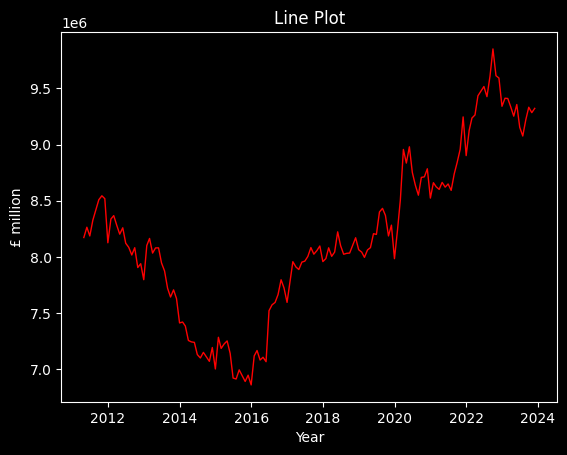

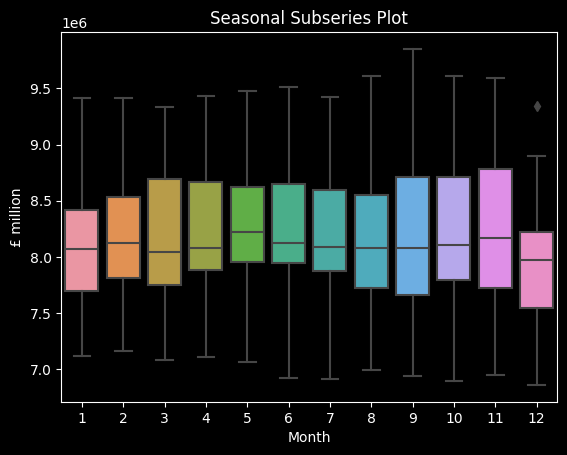

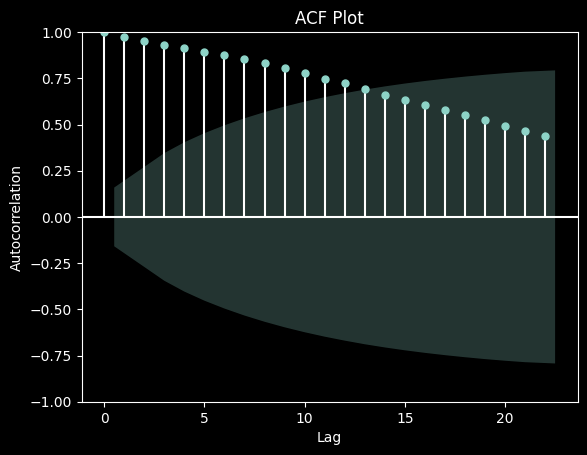

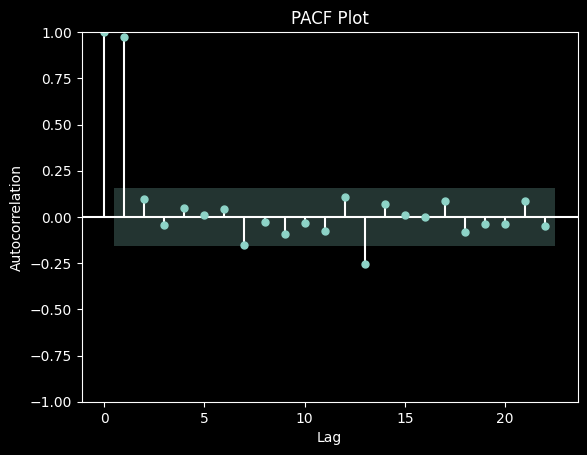

In [115]:
seasonality_visualised(monthly_all.TOTAL_ASSETS_STER_NSA)

#### 

### DECOMPOSITION OF THE TIME SERIES

See how I compare to statmodels

## DEALING WITH RESIDUALS

# EXPLORATORY DATA ANALYSIS

## DESCRIPTIVE STATISTICS

## IMPORTANT RELATIONSHIPS

## DEALING WITH ERRORS

# FORECASTING

In [23]:
#...

https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/totalbusinessinvestmentandgeneralgovernmentdataexcludingbritishnuclearfuelsbnfl - GFCF and TBI this was cleaned in google sheet and exported as csv